# Indy Archive Document Classification Project 

# Goal of this project
The goal of this project is to automate the document classification process by building a predictive model to classify them into categories of geography, time, person, and organization.

This categorization will facilitate archival and search of articles for years to come and get rid of the mundane tasks of reading and annotating articles manually.

# Importing required libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report
%matplotlib inline
from google.colab import files

In [2]:
uploaded = files.upload()

Saving Annotated Data - Deep Learning Project.csv to Annotated Data - Deep Learning Project (6).csv


# Understanding the Data

Reading the file

In [3]:
dataFrame= pd.read_csv("Annotated Data - Deep Learning Project.csv")

Checking the shape of the data


In [4]:
dataFrame.shape

(300, 4)

The dataset contains 300 rows and 4 rows

In [5]:
dataFrame.head(3)

,Body,Category,Unnamed: 2,Unnamed: 3
0,"(Jan 1, 1916-Nov 6, 1987). As a college studen...",Person,NaN,NaN
1,"(Dec. 24, 1880-Jan. 9, 1938). Born in Arcola, ...",Person,NaN,NaN
2,The building’s design was born out of the heig...,Time,NaN,NaN


Selecting only Body and Category Column as we need only these columns to perform analysis

In [6]:
dataFrame=dataFrame[['Body','Category']]

Displaying the first document

In [7]:
dataFrame['Body'][0]

"(Jan 1, 1916-Nov 6, 1987). As a college student Nellie M. Gilroy aimed toward a career in social service. The Atlanta, Georgia, native graduated cum laude from Agnes Scott College, Decatur, Georgia, and earned her masters degree in social work from Western Reserve University, Cleveland, Ohio. She pursued her career in Cleveland, Chicago, Houston, and the Virgin Islands before coming to Indianapolis in 1952 with her husband, Howard F. Gustafson, who served as executive director of the COMMUNITY SERVICE COUNCILof Metropolitan Indianapolis, and their three children. Gustafson served as associate director of the {INDIANAPOLIS URBAN LEAGUE}::EL from 1966 to 1975 when she became executive director of the {YOUNG WOMEN'S CHRISTIAN ASSOCIATION OF INDIANAPOLIS}::EL (YWCA). She came at a time of change; the organization was in temporary quarters on Fort Wayne Avenue, having closed the deteriorating headquarters at 329 Pennsylvania Street that it had occupied since 1909. Gustafson oversaw the mov

# Data Pre-Processing

1. Checking the null count in the columns

In [8]:
dataFrame.isnull().sum()

Body        0
Category    0
dtype: int64

Dropping the duplicates rows

In [9]:
dataFrame= dataFrame.drop_duplicates()

Counting the number of samples to perform analysis

In [10]:
dataFrame.count()

Body        299
Category    299
dtype: int64

2. Removing the special characters from the Body column which contains the articles


In [11]:
dataFrame['Body']=dataFrame['Body'].apply(lambda text: ' '.join(re.sub("[\.\,\<\>\?\\\/\{\}\[\]\+\=\-\_\(\)\`\~\!\$\%\^\&\*\;\:\''\"\#]"," ",text).split()))

3. Removing the words having more than 15 letters

In [12]:
dataFrame['Body'] = dataFrame['Body'].apply(lambda x: ' '.join(w for w in x.split() if len(w) < 15))

#Exploratory Data Analysis

Class distribution of response variable

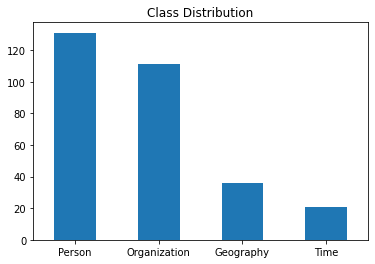

In [13]:
dataFrame['Category'].value_counts().plot.bar(rot=0, title= 'Class Distribution', x='Class', y='Frequency')

In [14]:
dataFrame['Category'].value_counts()

Person          131
Organization    111
Geography        36
Time             21
Name: Category, dtype: int64

Counting the number of words in each document

In [15]:
wordCount = lambda row: len(row['Body'].split(" "))
dataFrame['wordCount'] = dataFrame.apply(wordCount, axis=1)

Sorting the documents in the descending order of wordCount

In [16]:
dataFrame.sort_values(by= 'wordCount', ascending= False)

,Body,Category,wordCount
260,Reverend Nicholas McKay an associate of Dr Jam...,Organization,3670
246,Indianapolis felt the effects with full force ...,Time,2284
258,No other city can brag of having at one time o...,Organization,2197
248,On July 15 1889 five special trains carried hu...,Time,1953
247,About 1910 Indianapolis was considered the fou...,Time,1791
...,...,...,...
107,In October 1902 nautical buff Joe Stahr opened...,Organization,140
138,The line entered Indianapolis from the northea...,Geography,131
194,Organized by the federal government and admini...,Organization,128
88,Mitchell had practiced medicine in Kentucky fo...,Person,124


Counting the average number of words in each document

In [17]:
avg = np.round(dataFrame['wordCount'].mean())
avg

390.0

Average number of words in a document are 392

In [18]:
less_than_avg= 0
for count in dataFrame['wordCount']:
  if count<avg:
    less_than_avg+=1
print("Documents having word count less than the average:",less_than_avg)

Documents having word count less than the average: 203


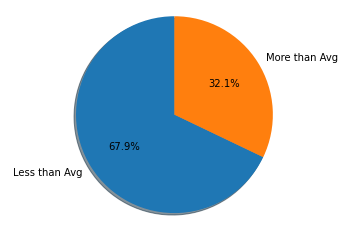

In [19]:
labels = 'Less than Avg', 'More than Avg'
sizes = [less_than_avg, len(dataFrame.wordCount) - less_than_avg]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  

plt.show()

# Load and Prepare Data for Modelling:

Dividing the data into Training and Validation Set

In [20]:
training_portion= 0.8
train_size = int(len(dataFrame) * training_portion)

train_articles = dataFrame['Body'][0: train_size]
train_labels = dataFrame['Category'][0: train_size]

validation_articles = dataFrame['Body'][train_size:]
validation_labels = dataFrame['Category'][train_size:]

print("Number of training articles: ",len(train_articles))
print("Number of training responses: ",len(train_labels))

print("Number of validation articles: ",len(validation_articles))
print("Number of validation responses: ",len(validation_labels))

Number of training articles:  239
Number of training responses:  239
Number of validation articles:  60
Number of validation responses:  60


In [21]:
print("Shape of training articles: ",train_articles.shape)
print("Shape of training response: ",train_labels.shape)

print("Shape of validation articles: ",validation_articles.shape)
print("Shape of validation responses: ",validation_labels.shape)

Shape of training articles:  (239,)
Shape of training response:  (239,)
Shape of validation articles:  (60,)
Shape of validation responses:  (60,)


In [22]:
train_articles.head(3)

0    Jan 1 1916 Nov 6 1987 As a college student Nel...
1    Dec 24 1880 Jan 9 1938 Born in Arcola Illinois...
2    The building’s design was born out of the heig...
Name: Body, dtype: object

Controlling the hyper-parameters

In [23]:
vocab_size = 8000
embedding_dim = 32
max_length = 300
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

Tokenizing the words

In [24]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index
dict(list(word_index.items())[:5])

{'<OOV>': 1, 'and': 3, 'in': 4, 'of': 5, 'the': 2}

In [25]:
train_sequences = tokenizer.texts_to_sequences(train_articles)

In [26]:
print(train_sequences[0])

[648, 111, 565, 1020, 293, 284, 12, 7, 97, 878, 5374, 528, 5375, 2163, 1109, 7, 466, 4, 146, 113, 2, 2164, 2527, 285, 529, 5376, 5377, 21, 3851, 3852, 97, 3023, 2527, 3, 1497, 99, 2165, 390, 4, 146, 126, 21, 446, 3853, 60, 1110, 274, 105, 3024, 99, 466, 4, 1110, 243, 5378, 3, 2, 5379, 5380, 134, 1667, 6, 8, 4, 949, 17, 99, 2166, 1668, 1669, 2528, 69, 76, 12, 697, 201, 5, 2, 61, 113, 5381, 698, 8, 3, 43, 114, 123, 2528, 76, 12, 2167, 201, 5, 2, 8, 566, 402, 11, 21, 496, 6, 567, 53, 105, 37, 697, 201, 5, 2, 317, 72, 14, 318, 70, 5, 8, 11, 1914, 105, 162, 16, 7, 71, 5, 1498, 2, 140, 10, 4, 2168, 2529, 20, 879, 745, 183, 1111, 798, 2, 3025, 336, 16, 5382, 361, 48, 24, 27, 38, 1499, 135, 467, 2528, 3026, 2, 403, 6, 2, 391, 5383, 130, 16, 5384, 5385, 184, 3, 2, 3854, 5, 2, 286, 163, 9, 2, 1914, 14, 235, 105, 2169, 65, 49, 1112, 1670, 34, 120, 3, 3855, 404, 1915, 9, 568, 224, 3, 287, 105, 1500, 9, 127, 2530, 4, 746, 2528, 10, 252, 4, 65, 49, 350, 5386, 1671, 7, 305, 5, 2170, 9, 99, 126, 105, 

Padding the training sequences till the maximum length of the article

In [27]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print("Length of training sequences before padding: ",len(train_sequences[0]))
print("Length of training sequences after padding: ",train_padded.shape[1])

Length of training sequences before padding:  272
Length of training sequences after padding:  300


Padding the training

In [28]:
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print("Length of validation sequences before padding: ", len(validation_sequences[0]))
print("Length of validation sequences after padding:",validation_padded.shape[1])

Length of validation sequences before padding:  279
Length of validation sequences after padding: 300


Tokenizing the labels 

In [29]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(dataFrame['Category'])

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
training_label_seq = np.subtract(training_label_seq,1) 

validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))
validation_label_seq = np.subtract(validation_label_seq,1) 
 
print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

[0]
[0]
[3]
(239, 1)
[1]
[2]
[0]
(60, 1)


# Building the model

In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          256000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 132       
Total params: 274,852
Trainable params: 274,852
Non-trainable params: 0
_________________________________________________________________


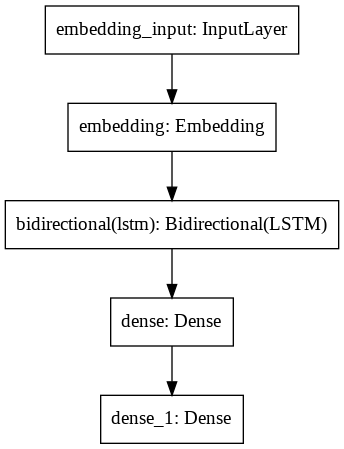

In [31]:
plot_model(model, to_file='model.png')

In [32]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 10
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/10
8/8 - 7s - loss: 1.3691 - accuracy: 0.3891 - val_loss: 1.3464 - val_accuracy: 0.3000
Epoch 2/10
8/8 - 2s - loss: 1.3082 - accuracy: 0.6151 - val_loss: 1.2831 - val_accuracy: 0.6000
Epoch 3/10
8/8 - 2s - loss: 1.2111 - accuracy: 0.7113 - val_loss: 1.1906 - val_accuracy: 0.6167
Epoch 4/10
8/8 - 2s - loss: 1.1069 - accuracy: 0.6736 - val_loss: 1.1502 - val_accuracy: 0.5500
Epoch 5/10
8/8 - 2s - loss: 0.9683 - accuracy: 0.7406 - val_loss: 1.1009 - val_accuracy: 0.5500
Epoch 6/10
8/8 - 2s - loss: 0.7950 - accuracy: 0.7071 - val_loss: 1.0207 - val_accuracy: 0.6833
Epoch 7/10
8/8 - 2s - loss: 0.6525 - accuracy: 0.7908 - val_loss: 1.0003 - val_accuracy: 0.6000
Epoch 8/10
8/8 - 2s - loss: 0.5415 - accuracy: 0.8033 - val_loss: 0.9104 - val_accuracy: 0.6167
Epoch 9/10
8/8 - 2s - loss: 0.4481 - accuracy: 0.8117 - val_loss: 0.9773 - val_accuracy: 0.6667
Epoch 10/10
8/8 - 2s - loss: 0.4219 - accuracy: 0.7992 - val_loss: 0.9418 - val_accuracy: 0.6333


# Final Results

Plotting Accuracy and Loss Plots

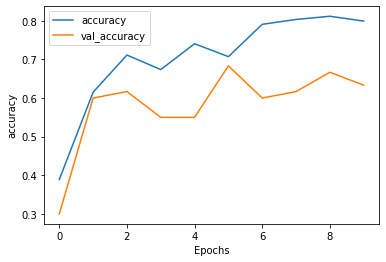

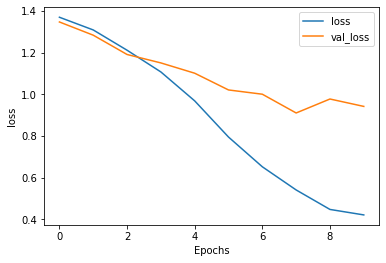

In [33]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Generating the Classifcation Report

In [34]:
y_pred = model.predict(validation_padded, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(validation_label_seq, y_pred_bool))

1/1 [==============================] - 1s 879ms/step
              precision    recall  f1-score   support

           0       0.73      0.97      0.83        31
           1       0.42      0.53      0.47        15
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         8

    accuracy                           0.63        60
   macro avg       0.29      0.38      0.33        60
weighted avg       0.48      0.63      0.55        60



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Prediction with a sample

In [35]:
txt= ["(Aug. 30, 1847-Feb. 13, 1925). Born in St. Gaul, Switzerland, Scherrer studied in Vienna and Budapest before immigrating to New York City in 1870. After a two-year stay in Chicago, he arrived in Indianapolis by 1873. His first position in this city was as draftsman to {EDWIN MAY}::EL , one of Indianapolis' leading architects. May, who was commissioned to design the new state capitol, died in 1880 before the plan was completed. Scherrer finished the design for the {STATE HOUSE}::EL , which was completed in 1888. Scherrer designed many late 19th century public edifices in Indianapolis. Included among them are the Gothic, spired arches at the 34th Street and Boulevard Place entrance to {CROWN HILL CEMETERY}::EL (1885); the Pathology Department (now the Old Pathology Building, 1896) at {CENTRAL STATE HOSPITAL}::EL , as well as many additions to the hospital; the Maennerchor Building at 502 North Illinois (since demolished), erected for instruction about and appreciation of the great German composers (1906); and the Independent Turnverein building at 902 North Meridian (1913), now upscale apartments. Scherrer was an innovative architect as well as a prolific one. Some of his later residential designs, including 4375 North Meridian Street (1911), were early examples of the Prairie School style of architecture created by Frank Lloyd Wright. In 1891, Mayor Thomas Sullivan appointed Scherrer to the first Indianapolis Board of Public Works, which was responsible for hiring the engineer who designed the citys first comprehensive sewage system. Scherrer's sons, Anton and Herman, also became well-known Indianapolis architects, working first in collaboration with their father and, after his death, on their own under the name Adolph Scherrer and Sons. Scherrer, who was a fellow in the American Institute of Architects, experienced a serious stroke six years before his death, which caused some paralysis and effectively ended his career. Many of his buildings still stand in Indianapolis."]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
labels = ['person', 'geography', 'organization', 'time']
print("The probability of this document belonging to different class is", pred )
print("The document belongs to "+ labels[np.argmax(pred)] + " category")

The probability of this document belonging to different class is [[0.9396353  0.02051915 0.0285731  0.01127241]]
The document belongs to person category


In [36]:
labels_tested =[]
for text in validation_padded:
  seq = tokenizer.texts_to_sequences(txt)
  padded = pad_sequences(seq, maxlen=max_length)
  pred = model.predict(padded)
  labels = ['person', 'geography', 'organization', 'time']
  labels_tested.append(labels[np.argmax(pred)])
